# Supplementary Figure 8

**Summary:**

- **Panel a:** Measure of strand bias at each locus in SSP experiments.

- **Panel b:** Unbiased locus presents a high concentration of SSP reads.

- **Panel c:** Unbiased locus in SSP Exp. are found biased in SL1/NP Exp.


---

<br>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

## Opening Dataset file

In [4]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [5]:
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

---

<br>

# Panel a: Measure of strand bias at each locus in SSP experiments

In [6]:
main_tss = genes_start[genes_start['total']>0].sort_values(['total','SL'], ascending=False).groupby(['gene']).head(1).reset_index(drop=True)

In [7]:
def measure_bias_at_locus(dataset):
    
    genes = []
    positions = []
    total_reads = []
    antisense_reads = []

    for (gene, position), table in dataset.groupby(['gene','corrected_genomic_start']):
        genes.append(gene)
        positions.append(position)
        total_reads.append(len(table))
        antisense_reads.append(len(table[table['read_orientation']=='antisense']))
    
    # build dataframe from lists and measure ratio
    locus_bias = pd.DataFrame(dict(gene=genes, position=positions, total_exp=total_reads, antisense=antisense_reads))
    locus_bias['sense'] = locus_bias['total_exp'] - locus_bias['antisense']
    locus_bias['antisense_ratio'] = round(locus_bias['antisense']/locus_bias['total_exp'], 2)
    
    return locus_bias

In [8]:
locus_bias_SSP = measure_bias_at_locus(dataset[dataset['run'].str.contains('SSP')])
locus_bias_SSP = main_tss.merge(locus_bias_SSP, on=['gene', 'position'], how='left')

In [9]:
def plot_bias_at_locus(locus_bias, min_reads=None):
    
    # Generate plot
    %matplotlib inline

    sns.set_style('ticks')
    plt.figure(figsize=(7,6), dpi=500)
    
    if min_reads:
        unused = locus_bias[locus_bias['total_exp'] < min_reads]
        used = locus_bias[locus_bias['total_exp'] >= min_reads]

        ### Plot biased locus bias
        x = list(unused['total_exp'])
        y = list(unused['antisense'])
        plt.scatter(x, y, s=12, c='white', edgecolor='k', linewidth=0.2, zorder=10)

        x = list(used['total_exp'])
        y = list(used['antisense'])
        plt.scatter(x, y, s=12, c='lightgrey', edgecolor='k', linewidth=0.2, zorder=10)

        ### Highlight locus with no significant bias
        bias = used[used['antisense_ratio']<=0.6]
        x = list(bias['total_exp'])
        y = list(bias['antisense'])
        plt.scatter(x, y, s=12, c='r', edgecolor='k', linewidth=0.2, zorder=10)
        
    else:
        x = list(locus_bias['total_exp'])
        y = list(locus_bias['antisense'])
        plt.scatter(x, y, s=12, c='#f5f4f2', edgecolor='k', linewidth=0.2, zorder=10)

        ### Highlight locus with no significant bias
        bias = locus_bias[locus_bias['antisense_ratio']<=0.6]
        x = list(bias['total_exp'])
        y = list(bias['antisense'])
        plt.scatter(x, y, s=12, c='r', edgecolor='k', linewidth=0.2, zorder=10)
        

    # 100% ratio line
    plt.plot([0, 10**5], [0, 10**5], 'k--', linewidth=1, zorder=1)
    
    ### plot settings
    plt.xlabel('Total reads at locus', weight='bold')
    plt.ylabel('Antisense reads at locus', weight='bold')
    plt.xscale('symlog', subs=[2,3,4,5,6,7,8,9])
    plt.yscale('symlog', subs=[2,3,4,5,6,7,8,9])
    plt.xlim(0.8, 10**5)
    plt.ylim(-0.2, 10**5)
    
    plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=True, left=True)
    plt.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
    plt.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)
    plt.tick_params(axis='x', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, bottom=True)
    plt.tick_params(axis='x', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, bottom=True)


In [10]:
total = len(locus_bias_SSP[locus_bias_SSP['total_exp'] >= 50])
print(f'Genes with 50 reads or more at locus: {total} genes')

Genes with 50 reads or more at locus: 1146 genes


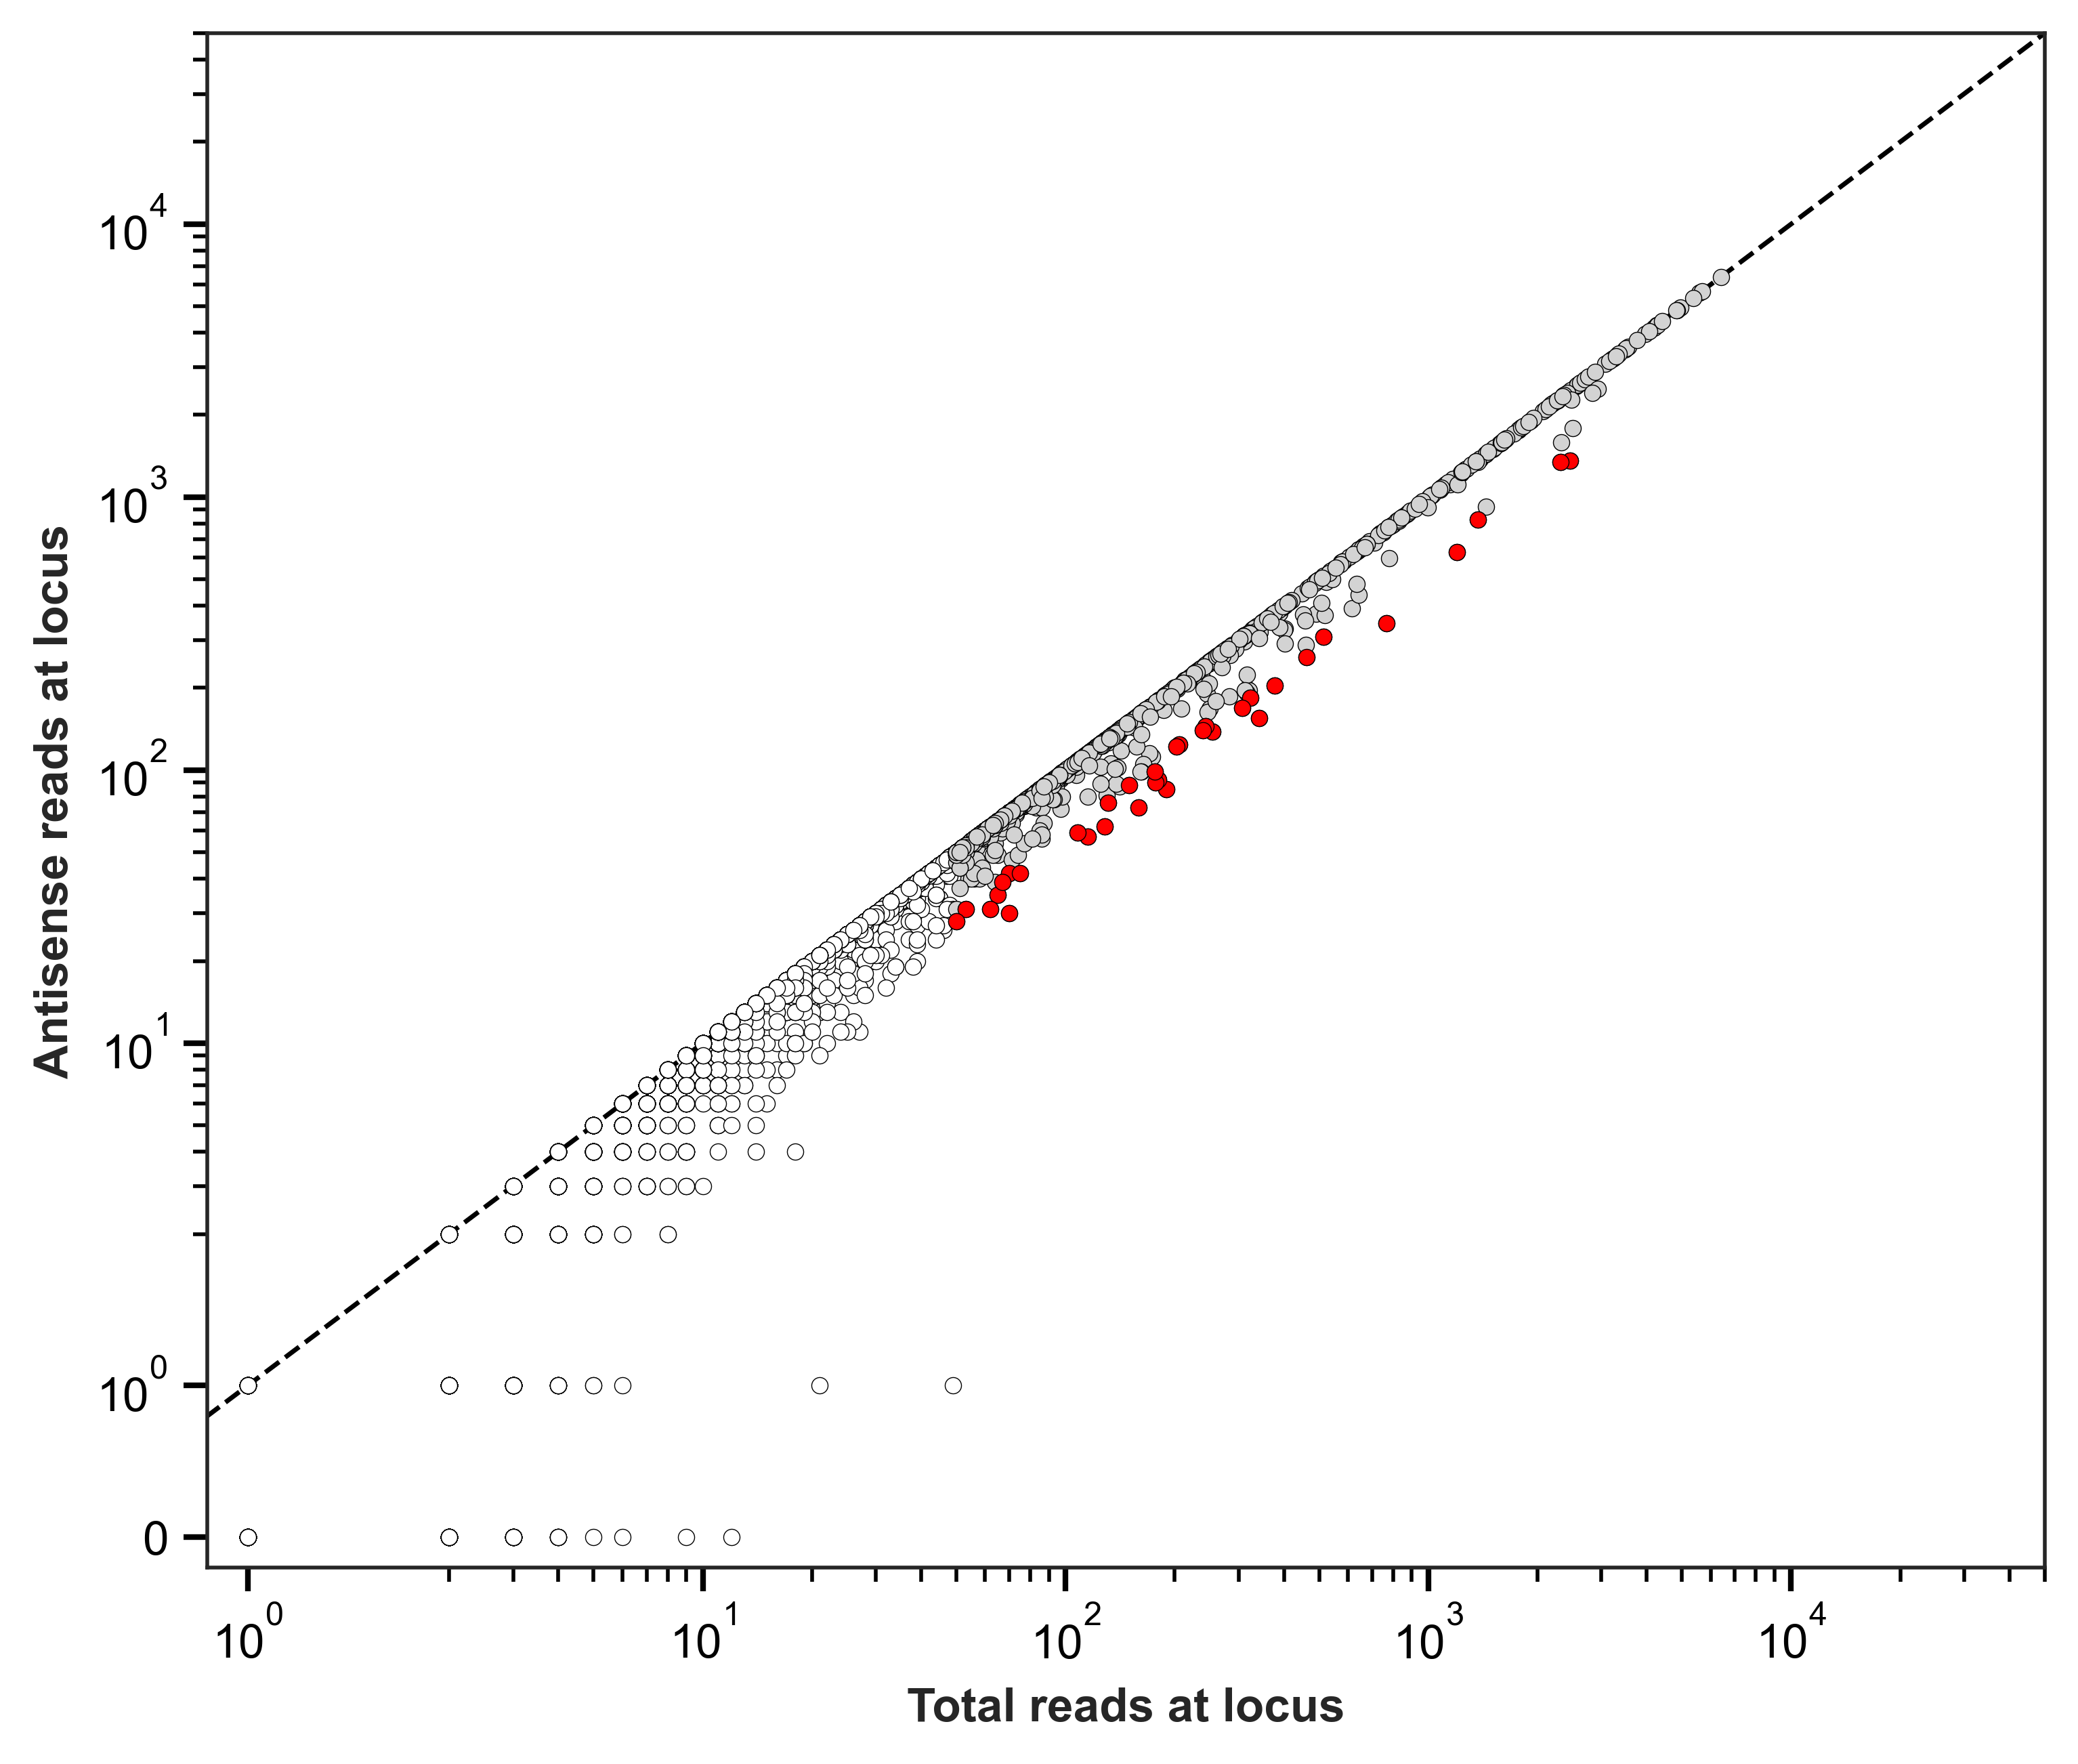

In [11]:
plot_bias_at_locus(locus_bias_SSP, min_reads=50)

plt.xlim(0.8, 5*10**4)
plt.ylim(-0.2, 5*10**4)

plt.savefig('SupFig8.a-strand_bias_at_locus(SSP_dataset).png', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 8.a:**<br></font>
For each gene detected in the SSP dataset, we selected the most frequent 5’
alignment start position and, if they had at least 50 reads, we plotted the number of
antisense reads vs the total number of reads present at the position (n=1,146). The 31
genes displaying 60% or less antisense reads are highlighted in red.

<br>

# Panel b: Unbiased locus presents a high concentration of SSP reads

In [12]:
def measure_SSP_at_locus(dataset, main_tss=main_tss):
    
    # determine main tss positions
    main_tss_positions = main_tss.set_index('gene')['position'].to_dict()
    
    # measure %SSP at locus
    genes = []
    total = []
    SSP_reads = []
    SL_reads = []
    HAIRPIN_reads = []
    antisense_reads = []

    for (gene,pos), table in dataset.groupby(['gene','corrected_genomic_start']):
        
        if gene in main_tss_positions and pos == main_tss_positions[gene]:
            genes.append(gene)
            total.append(len(table))
            SL_reads.append(len(table[table['ROBUST_SL_FOUND']=='FOUND']))
            HAIRPIN_reads.append(len(table[table['HAIRPIN_FOUND']=='FOUND']))
            SSP_reads.append(len(table[table['SSP_FOUND']=='FOUND']))
            antisense_reads.append(len(table[table['read_orientation']=='antisense']))

    SSP_stats = pd.DataFrame(dict(gene=genes, total=total, SSP_reads=SSP_reads, antisense_reads=antisense_reads,
                                 SL_reads=SL_reads, HAIRPIN_reads=HAIRPIN_reads))
    
    SSP_stats['%SSP'] = round(SSP_stats['SSP_reads']/SSP_stats['total']*100, 2)
    SSP_stats['%SL'] = round(SSP_stats['SL_reads']/SSP_stats['total']*100, 2)
    SSP_stats['%HAIRPIN'] = round(SSP_stats['HAIRPIN_reads']/SSP_stats['total']*100, 2)
    SSP_stats['antisense_ratio'] = round(SSP_stats['antisense_reads']/SSP_stats['total']*100, 2)
    
    return SSP_stats

In [13]:
def plot_bias_per_SSP(dataset):
    
    # Generate plot
    %matplotlib inline

    sns.set_style('white')
    plt.figure(figsize=(7,6), dpi=500)
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataset['antisense_ratio'], dataset['%SSP'])

    # measure R2 value
    r2 = round(r_value**2, 2)
    
    plt.vlines(50, -1, 101, 'r', linestyle=':', linewidth=1, zorder=0)
    plt.vlines(40, -1, 101, 'r', linestyle=':', linewidth=1, zorder=0)
    plt.vlines(60, -1, 101, 'r', linestyle=':', linewidth=1, zorder=0)
    plt.axvspan(40, 60, alpha=0.1, color='red', zorder=-10)
    
    ### Plot locus bias
    ax = sns.regplot(x="antisense_ratio", y="%SSP", data=dataset, ci=None, line_kws={'label': f"R2={r2}", 'color':'k', 'linewidth':1}, 
                     scatter_kws={'color':'lightgrey', 'edgecolor':'k', 'linewidth':0.2, 's':12})
    
    plt.scatter(x="antisense_ratio", y="%SSP", data=dataset[dataset['antisense_ratio']<=60], 
                s=12, c='red', edgecolor='k', linewidth=0.2, zorder=10)
    
    
    plt.text(86,96, f'R\u00b2={r2}', weight='bold', size=12)
    
    plt.xlim(-1, 101)
    plt.ylim(-1, 101)
    
    ax.set_xticks([i for i in range(0,110,10)], minor=True)
    ax.set_yticks([i for i in range(0,110,10)], minor=True)
 
    ax.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=True, left=True)
    ax.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
    ax.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)
    ax.tick_params(axis='x', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, bottom=True)
    ax.tick_params(axis='x', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, bottom=True)

    

In [14]:
SSP_stats = measure_SSP_at_locus(dataset[dataset['run'].str.contains('SSP')])

In [15]:
n_unbiased = len(SSP_stats[(SSP_stats.total >= 50) & (SSP_stats.antisense_ratio <= 60)])
print(f'Genes with 60% or less antisense reads at locus: {n_unbiased} genes')

n_biased = len(SSP_stats[(SSP_stats.total >= 50) & (SSP_stats.antisense_ratio > 60)])
print(f'Genes with more than 60% antisense reads at locus: {n_biased} genes')

Genes with 60% or less antisense reads at locus: 31 genes
Genes with more than 60% antisense reads at locus: 1115 genes


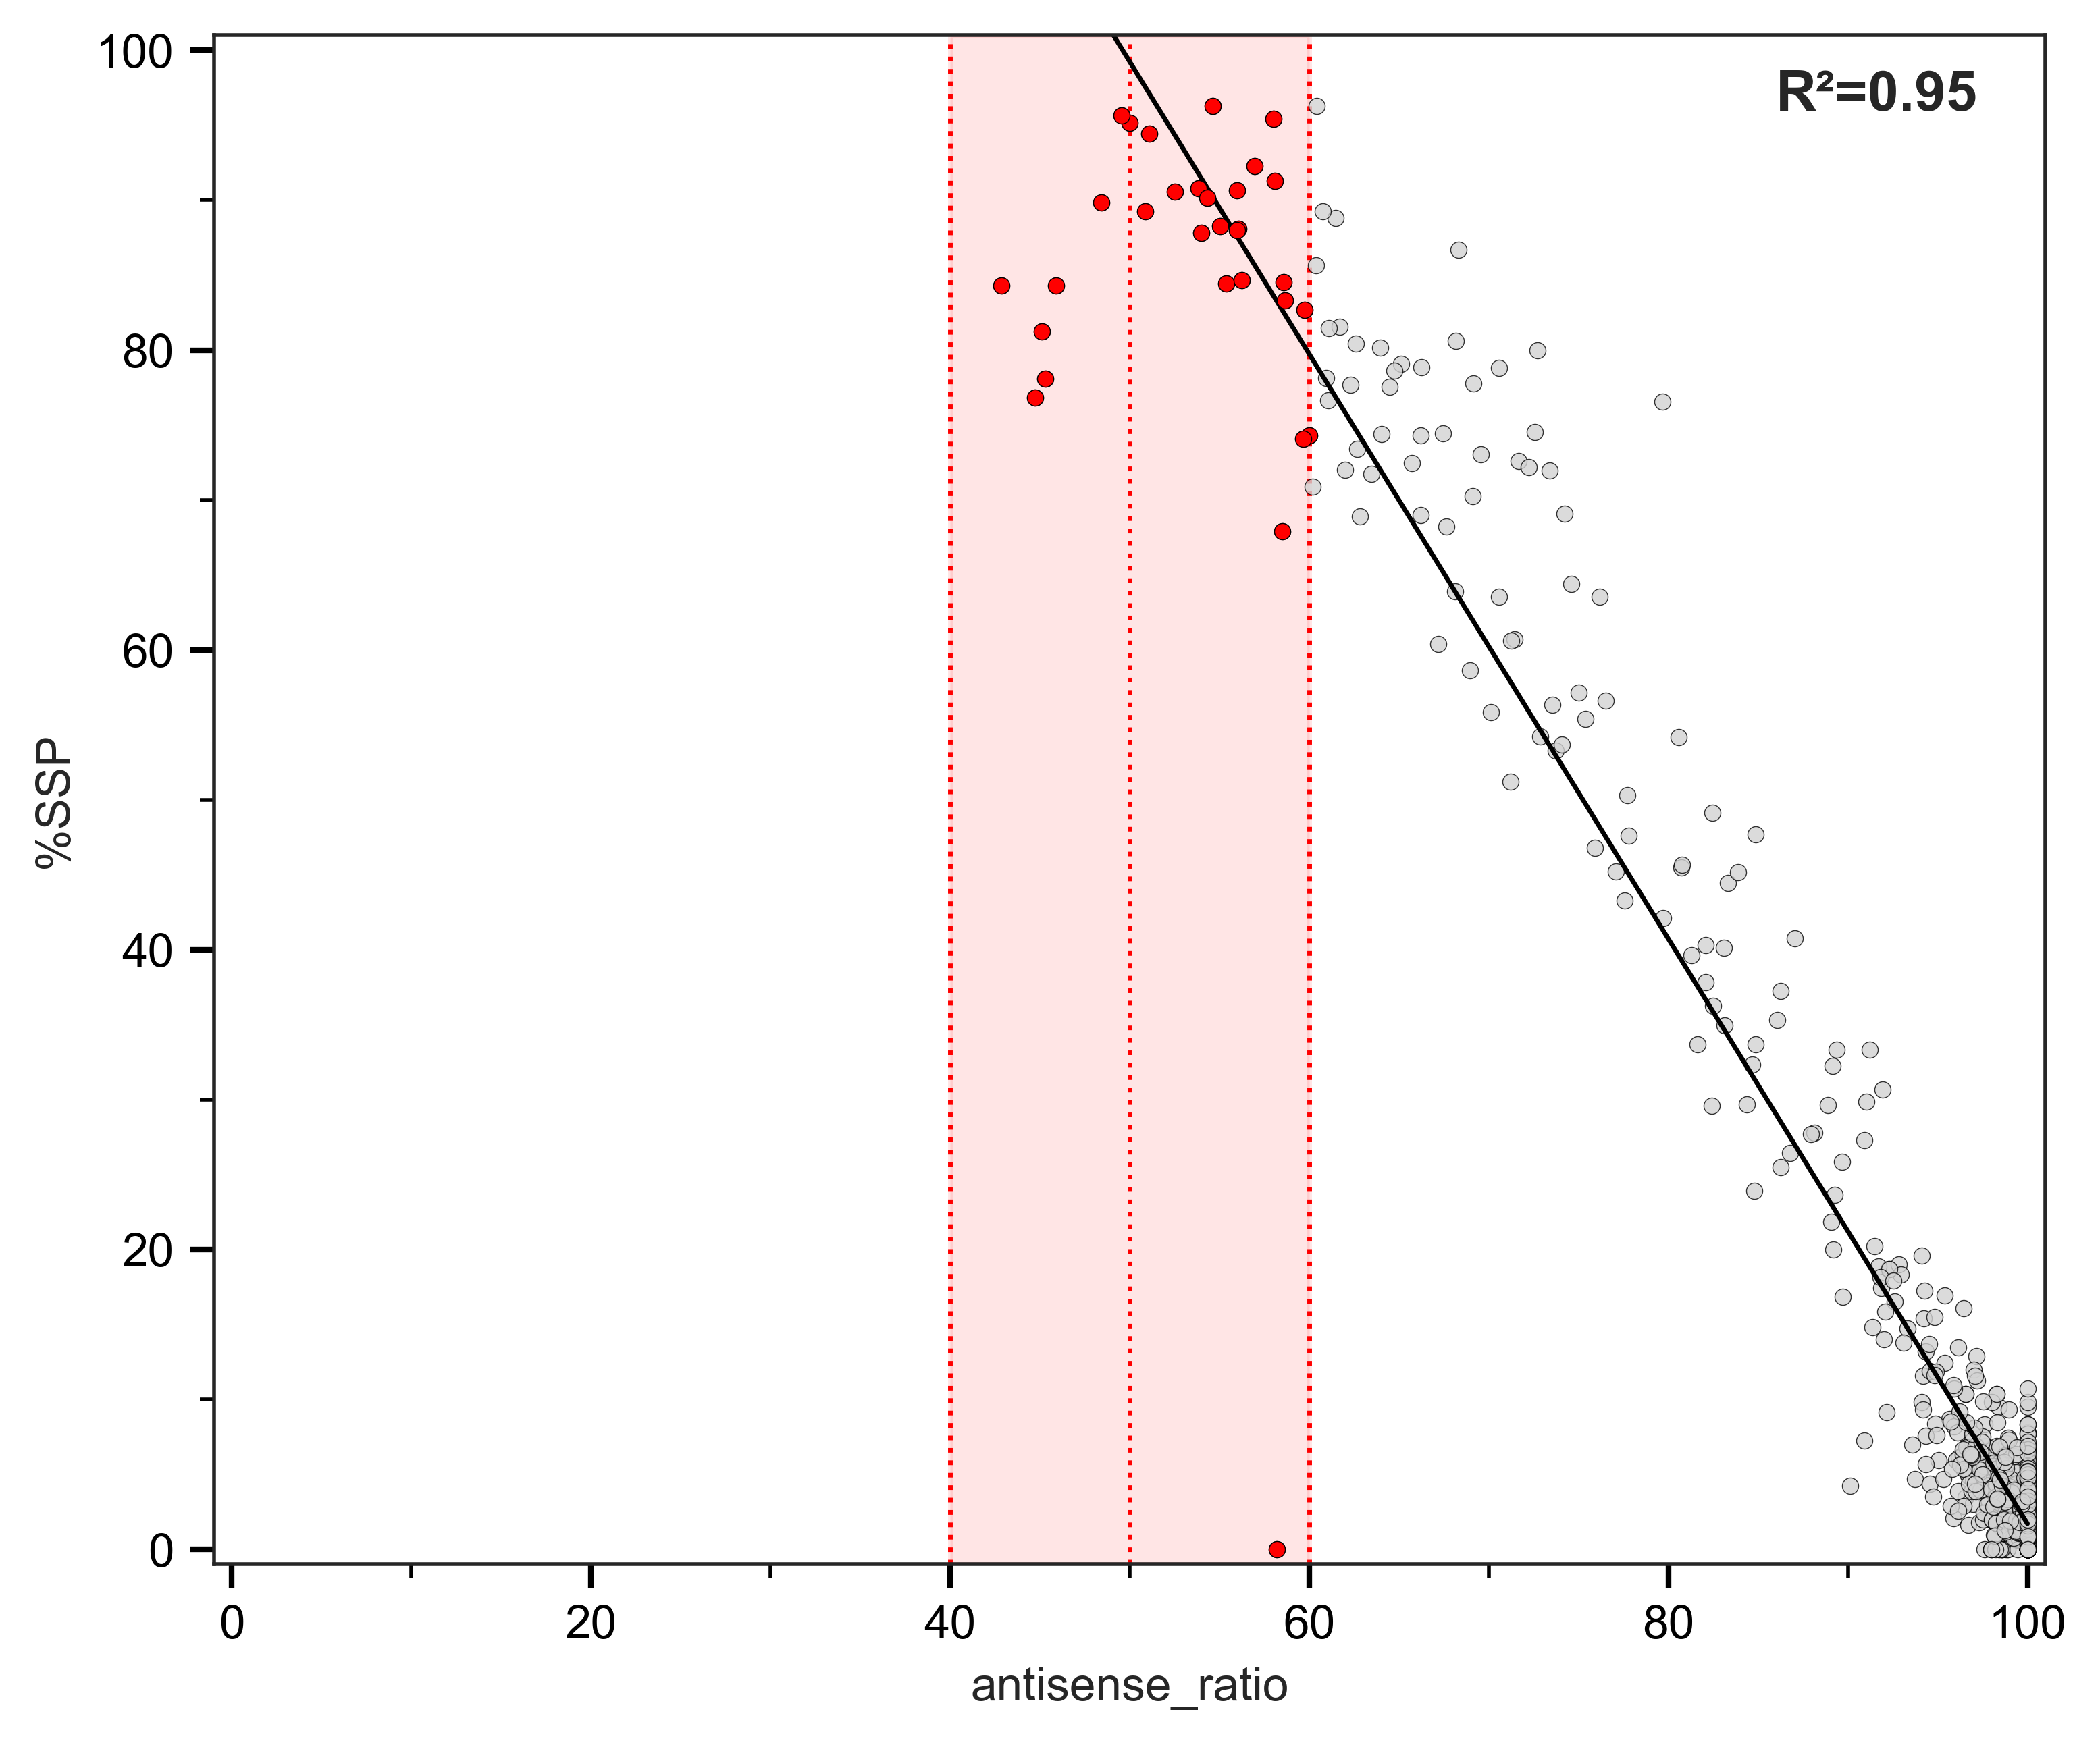

In [16]:
plot_bias_per_SSP(SSP_stats[SSP_stats.total >= 50])

plt.savefig('SupFig8.b-SSP_reads_versus_antisense_reads(SSP_dataset).png', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 8.b:**<br></font>
Linear regression analysis for the number of antisense reads (x-axis) and the percentage of reads for which we could detect the Strand Switching Primer (SSP) sequence (y-axis) in SSP datasets.

<br>

# Panel c: Unbiased locus in SSP Exp. are found biased in SL1/NP Exp.

In [17]:
ssp_biased = list(SSP_stats[(SSP_stats.total >= 50) & (SSP_stats.antisense_ratio > 60)]['gene'])
ssp_unbiased = list(SSP_stats[(SSP_stats.total >= 50) & (SSP_stats.antisense_ratio <= 60)]['gene'])

In [18]:
SL1_stats = measure_SSP_at_locus(dataset[dataset['run'].str.contains('SL1')])

sl1_biased = SL1_stats[SL1_stats['gene'].isin(ssp_biased)]
sl1_unbiased = SL1_stats[SL1_stats['gene'].isin(ssp_unbiased)]

In [19]:
NP_stats = measure_SSP_at_locus(dataset[dataset['run'].str.contains('NP')])

np_biased = NP_stats[NP_stats['gene'].isin(ssp_biased)]
np_unbiased = NP_stats[NP_stats['gene'].isin(ssp_unbiased)]

In [20]:
def plot_unbiased_genes(biased_gene, unbiased_genes, dataset_ID, ax):
    
    ### Plot locus bias
    ax.scatter(x="total", y="antisense_reads", data=biased_gene, s=12, c='lightgrey', edgecolor='k', linewidth=0.2, zorder=10)
    ax.scatter(x="total", y="antisense_reads", data=unbiased_genes, s=12, c='red', edgecolor='k', linewidth=0.2, zorder=10)
    
    if dataset_ID:
        ax.text(1, 50000, f'{dataset_ID} Datasets', weight='bold')

    # 100% ratio line
    ax.plot([0, 10**5], [0, 10**5], 'k--', linewidth=1, zorder=1)

    ### plot settings
    ax.set_xlabel('total reads at locus', weight='bold')
    ax.set_ylabel('antisense reads at locus', weight='bold')
    ax.set_xscale('symlog', subs=[2,3,4,5,6,7,8,9])
    ax.set_yscale('symlog', subs=[2,3,4,5,6,7,8,9])
    ax.set_xlim(0.8, 10**5)
    ax.set_ylim(-0.2, 10**5)

    ax.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=True, left=True)
    ax.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
    ax.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)
    ax.tick_params(axis='x', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, bottom=True)
    ax.tick_params(axis='x', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, bottom=True)
    

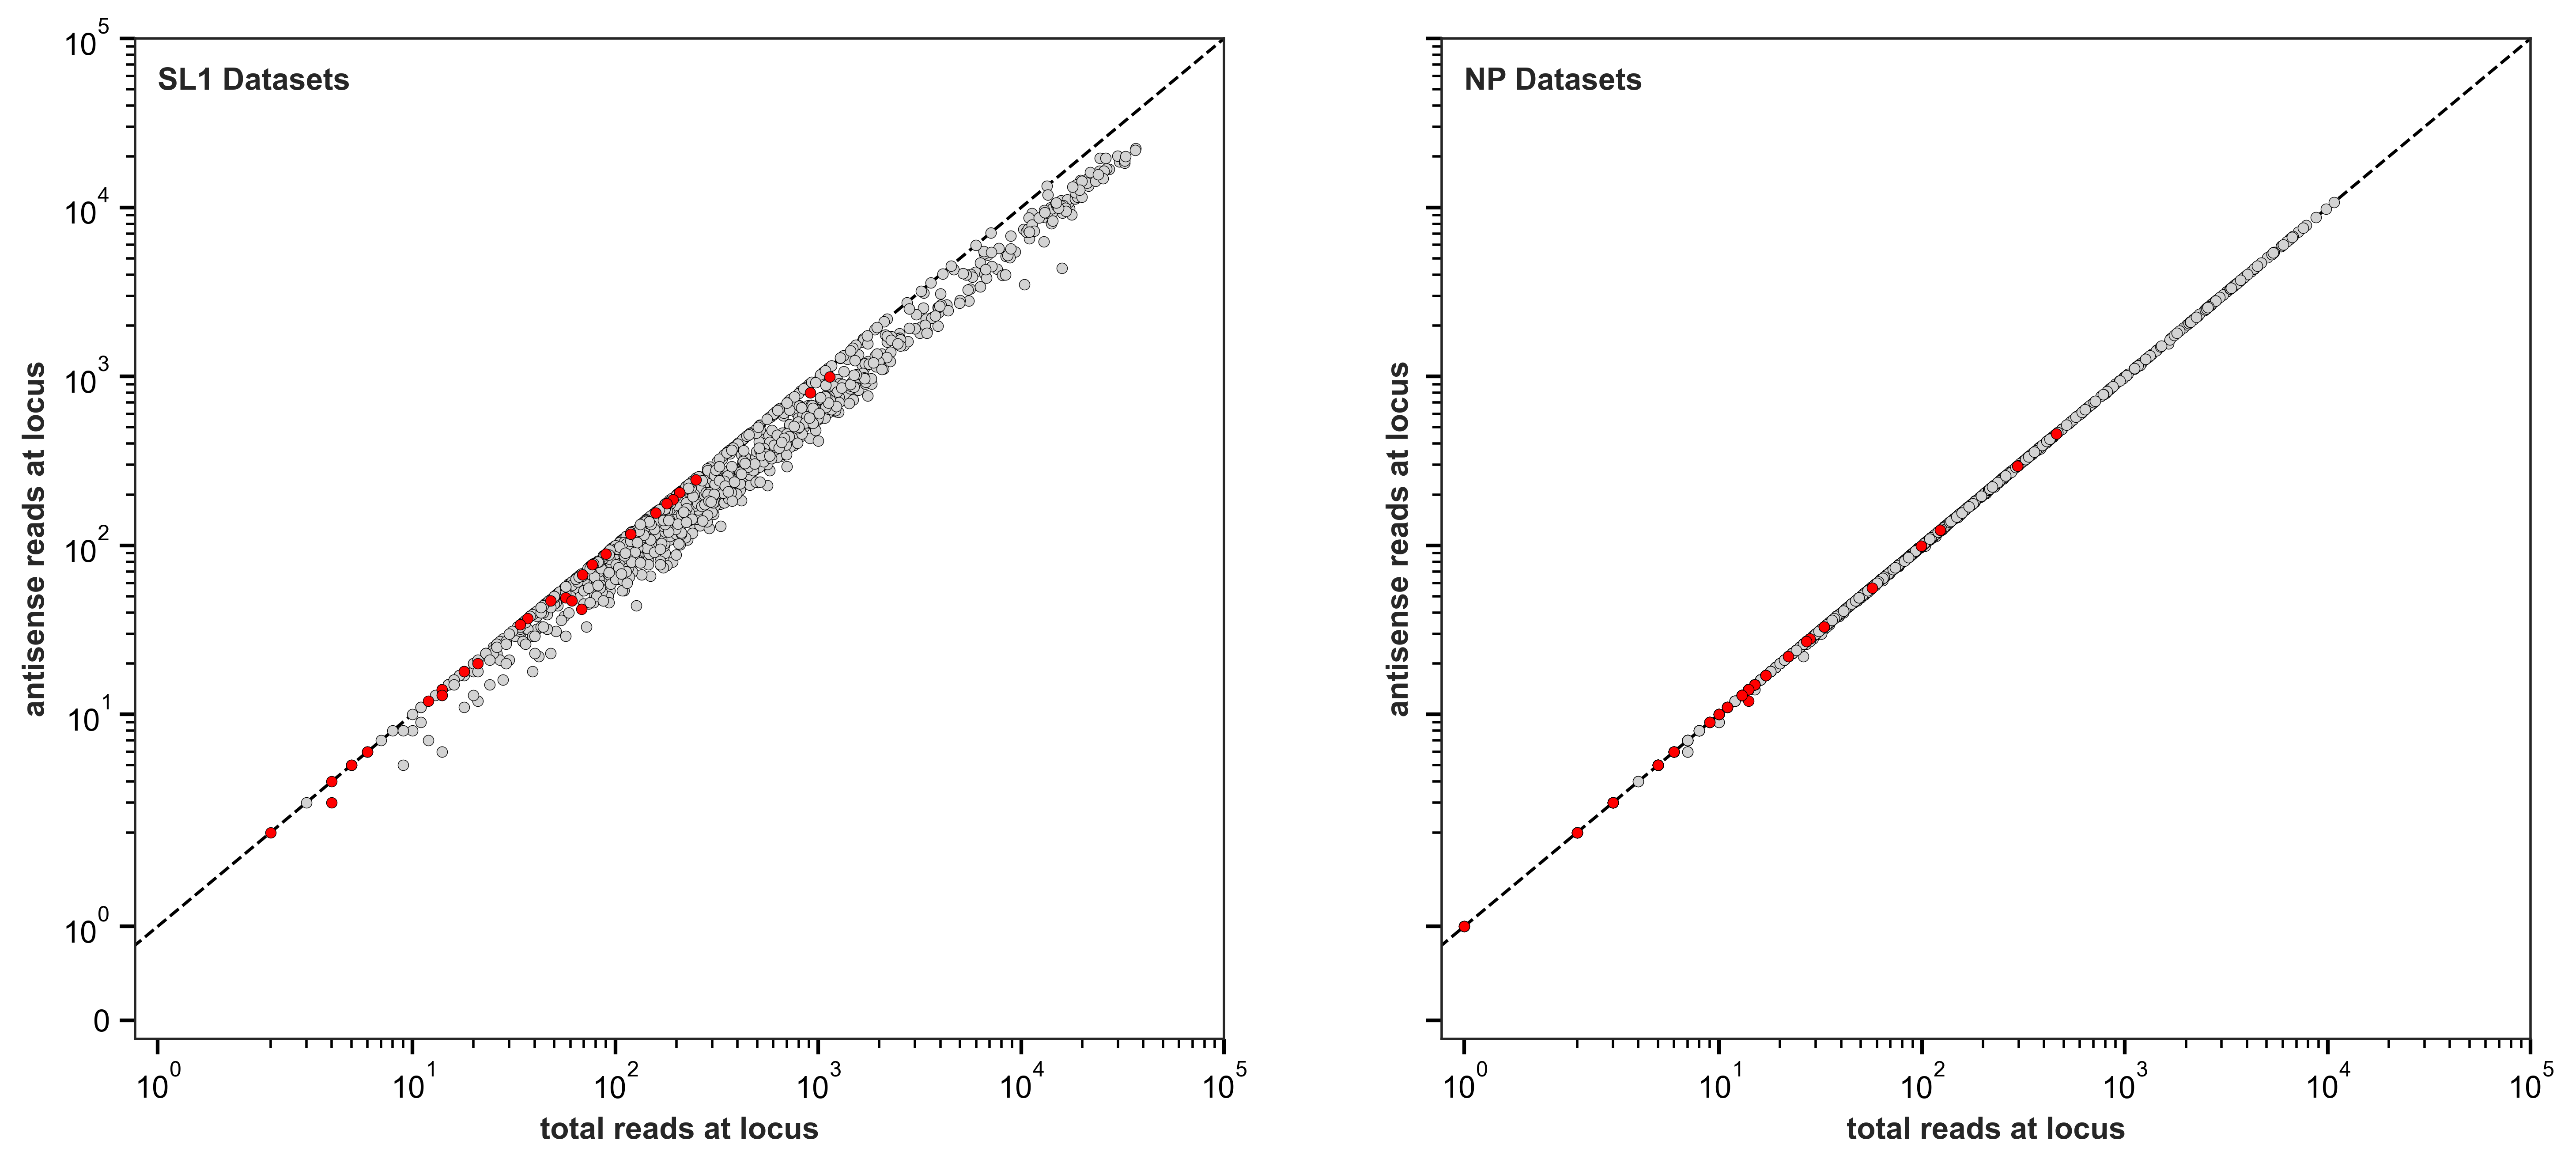

In [21]:
# Generate plot
%matplotlib inline

sns.set_style('white')

fig, ax = plt.subplots(figsize=(14, 6), dpi=500, ncols=2, nrows=1, sharey=True, )

plot_unbiased_genes(sl1_biased, sl1_unbiased, 'SL1', ax[0])
plot_unbiased_genes(np_biased, np_unbiased, 'NP', ax[1])

plt.savefig('SupFig8.c-total_reads_vs_antisense(SL1_and_NP_datasets).png', dpi=500, bbox_inches='tight')

<font size="4">**Sup. Fig 8.c:**<br></font>
For each locus, we plotted the total number of reads vs the number of antisense reads as
shown in panel a considering only reads obtained in the SL1 dataset (left) and the NP
datasets (right). As above, genes high proportion of antisense reads in the SSP datasets are
shown in red.